<a href="https://colab.research.google.com/github/Indian-otaku/Introduction_To_PyTorch/blob/main/classification_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all necessary modules 

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

torch.__version__

'1.13.1+cu116'

## Device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Making data and converting to tensors

In [ ]:
N_CLASSES = 4
N_FEATURES = 2
RANDOM_SEED = 42

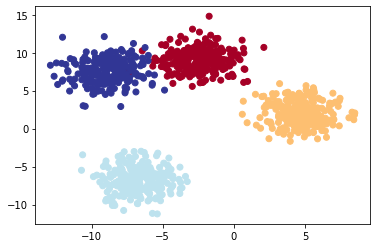

In [ ]:
X_blobs, y_blobs = make_blobs(n_samples=1000,
                              n_features=N_FEATURES,
                              centers=N_CLASSES,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

# Conversion to tensor
X_blobs = torch.from_numpy(X_blobs).type(torch.float).to(device)
y_blobs = torch.from_numpy(y_blobs).type(torch.LongTensor).to(device)

# Devide into train and test 
X_train, X_test, y_train, y_test = train_test_split(X_blobs, 
                                                    y_blobs,
                                                    train_size=0.8,
                                                    random_state=RANDOM_SEED)

# Plot the data
plt.scatter(X_blobs[:, 0].detach().cpu(),
            X_blobs[:, 1].detach().cpu(),
            c=y_blobs.detach().cpu(),
            cmap=plt.cm.RdYlBu)
plt.show()

## Building a multiclass classification model

In [ ]:
class MultiClassClassification(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden_layers=8):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=n_features,
                      out_features=n_hidden_layers,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden_layers,
                      out_features=n_hidden_layers,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Linear(in_features=n_hidden_layers,
                      out_features=n_classes,
                      bias=True,
                      device=device,
                      dtype=torch.float)
        )
    def forward(self, x):
        return self.layers(x)
    

In [ ]:
model1 = MultiClassClassification(n_features=N_FEATURES,
                                  n_classes=N_CLASSES,
                                  n_hidden_layers=8).to(device)

model1.state_dict()

OrderedDict([('layers.0.weight', tensor([[ 0.3329, -0.4778],
                      [-0.5429, -0.5591],
                      [-0.5186, -0.3741],
                      [-0.3525, -0.3353],
                      [ 0.0127,  0.4419],
                      [ 0.5806, -0.6248],
                      [ 0.4487,  0.3687],
                      [-0.3174,  0.0852]], device='cuda:0')),
             ('layers.0.bias',
              tensor([-0.3520, -0.3166, -0.2411,  0.6622,  0.6214,  0.0721,  0.2866,  0.6436],
                     device='cuda:0')),
             ('layers.2.weight',
              tensor([[ 0.2891,  0.1979,  0.3317, -0.2486, -0.3319, -0.3144, -0.1939,  0.2128],
                      [-0.0896, -0.0092,  0.1670,  0.0355, -0.1463, -0.1634,  0.1723, -0.2023],
                      [-0.0313,  0.3324, -0.2355,  0.1723, -0.2233, -0.0703,  0.2792, -0.1931],
                      [-0.3410,  0.2572, -0.0910,  0.0331,  0.0315,  0.1525, -0.1533, -0.2194],
                      [-0.2581,  0.3347,  

In [ ]:
model1.eval()
with torch.inference_mode():
    y_logits = model1(X_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

y_pred[:10]

tensor([1, 2, 0, 3, 2, 2, 0, 2, 0, 2], device='cuda:0')

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5]}]}

In [ ]:
def accuracy_fn(y_pred=None, y_true=None):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct / len(y_pred))*100

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 100

for epoch in range(epochs):
    model1.train()

    y_logits_train = model1(X_train)
    y_loss_train = loss_fn(y_logits_train, y_train)

    model1.zero_grad()
    y_loss_train.backward()
    optimizer.step()

    if (epoch%20 == 0):
        model1.eval()
        with torch.inference_mode():
            y_logits_test = model1(X_test)
            y_loss_test = loss_fn(y_logits_test, y_test)

            y_pred_probs_train = torch.softmax(y_logits_train, dim=1)
            y_pred_probs_test = torch.softmax(y_logits_test, dim=1)
            
            y_pred_train = torch.argmax(y_pred_probs_train, dim=1)
            y_pred_test = torch.argmax(y_pred_probs_test, dim=1)

        print(f"Epoch:{epoch}|Train loss:{y_loss_train}|Train acc:{accuracy_fn(y_pred_train, y_train)}\
        |Test loss:{y_loss_test}|Test acc:{accuracy_fn(y_pred_test,y_test)}")



Epoch:0|Train loss:1.4611941576004028|Train acc:15.875        |Test loss:1.1922494173049927|Test acc:50.0
Epoch:20|Train loss:0.3061039447784424|Train acc:98.5        |Test loss:0.2546268701553345|Test acc:100.0
Epoch:40|Train loss:0.06458593904972076|Train acc:99.125        |Test loss:0.052945952862501144|Test acc:99.5
Epoch:60|Train loss:0.04320878908038139|Train acc:99.125        |Test loss:0.033493105322122574|Test acc:99.5
Epoch:80|Train loss:0.03597647324204445|Train acc:99.125        |Test loss:0.02658316120505333|Test acc:99.5


In [ ]:
model1.eval()
with torch.inference_mode():
    y_logits = model1(X_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

(y_pred == y_test).sum().item() / len(y_pred)

0.995

In [ ]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


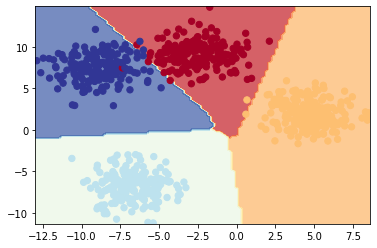

In [ ]:
plot_decision_boundary(model1, X_train, y_train)

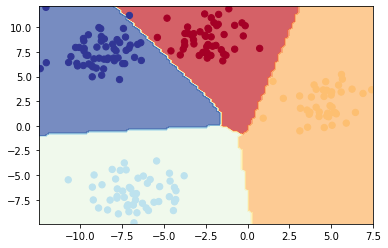

In [ ]:
plot_decision_boundary(model1, X_test, y_test)

In [ ]:
# !pip install torchmetrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 34.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
print(accuracy(y_pred, y_test))

tensor(0.9950, device='cuda:0')
